# Topic modeling on ireland-timeline textual data

## Importing libraries

In [1]:
import sys
sys.path.append("/home/jovyan/work/sem-covid/")
sys.path = list(set(sys.path))

import os
os.getcwd()
os.chdir('/home/jovyan/work/sem-covid/')

import numpy as np
np.random.seed(42)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import spacy
nlp = spacy.load("en_core_web_sm")

import gensim
import pandas as pd
import pyLDAvis.gensim_models
import matplotlib.colors as mcolors

from sklearn.manifold import TSNE
from bokeh.io import output_notebook
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource

from gensim.models import LdaModel, LsiModel
from sem_covid.entrypoints.notebooks.topic_modeling.topic_modeling_wrangling.topic_visualizer import generate_wordcloud
from sem_covid.services.data_registry import Dataset
from sem_covid.services.sc_wrangling.data_cleaning import clean_text_from_specific_characters, clean_fix_unicode, \
    clean_remove_currency_symbols, clean_remove_emails, clean_remove_urls
from sem_covid.entrypoints.notebooks.topic_modeling.topic_modeling_wrangling.token_management import filter_stop_words,\
    filter_pos, filter_stop_words_on_a_span_list, select_pos, spacy_stop_words

/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:164: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=n

## Fetching data from document store

In [2]:
ireland_timeline = Dataset.IRELAND_ACTION_TIMELINE.fetch()

ireland_timeline.fillna(value="", inplace=True)

document_corpus = ireland_timeline['title'].map(str) + '. ' + \
                  ireland_timeline['content'].map(str)

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

100% (410 of 410) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


## Data preprocessing

- data cleanup
- turn corpus into spacy Docs

In [3]:
unused_characters = ["\\r", ">", "\n", "\\", "<", "''", "%", "...", "\'", '"', "(", "\n", "*", "1)", "2)", "3)",
                     "[", "]", "-", "_", "\r"]

document_corpus = document_corpus.apply(clean_text_from_specific_characters, characters=unused_characters)
document_corpus = document_corpus.apply(clean_fix_unicode)
document_corpus = document_corpus.apply(clean_remove_urls)
document_corpus = document_corpus.apply(clean_remove_emails)
document_corpus = document_corpus.apply(clean_remove_currency_symbols)
spacy_corpus = document_corpus.apply(nlp)

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



## Preparing few corpora

Filter document tokens. Select only the needed/interesting tokens for Topic modeling:
   - all words
   - nouns
   - verbs
   - noun phrases

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



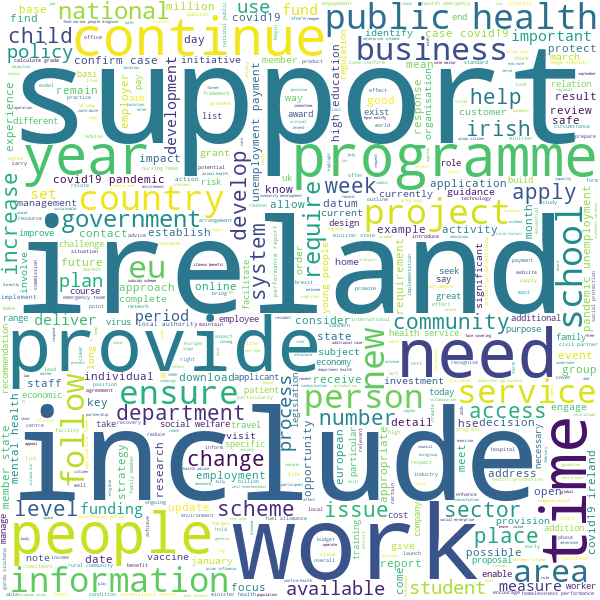

In [4]:
word_corpus = spacy_corpus.apply(filter_stop_words, stop_words=spacy_stop_words)
word_corpus = word_corpus.apply(filter_pos, pos="PUNCT")
word_corpus = word_corpus.apply(lambda x: list(map(lambda docs: docs.lemma_,x)))

generate_wordcloud(" ".join( [" ".join(doc) for doc in word_corpus]) )

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



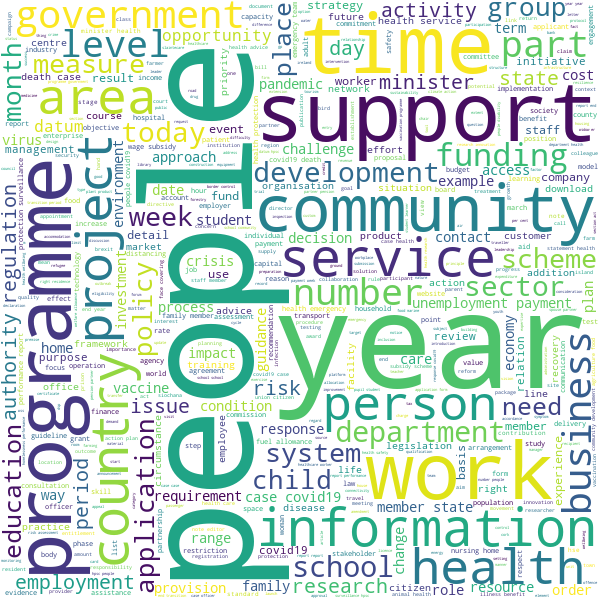

In [5]:
noun_corpus = spacy_corpus.apply(select_pos, pos="NOUN")
noun_corpus = noun_corpus.apply(lambda x: list(map(lambda docs: docs.lemma_,x)))

generate_wordcloud(" ".join( [" ".join(doc) for doc in noun_corpus]) )

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



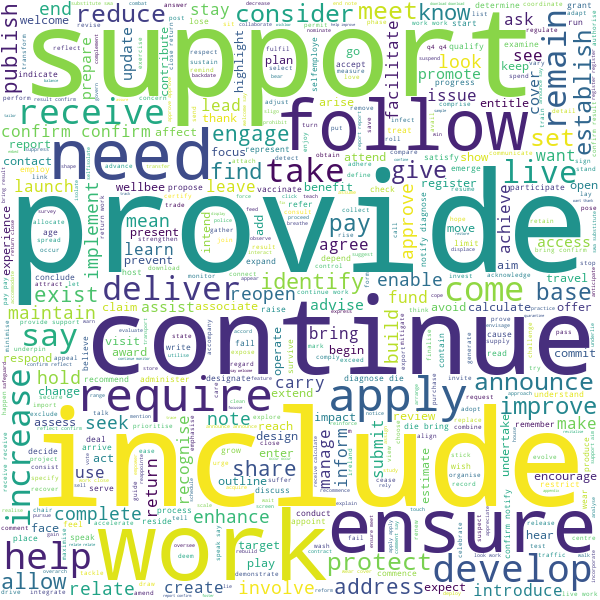

In [6]:
verb_corpus = spacy_corpus.apply(select_pos, pos="VERB")
verb_corpus = verb_corpus.apply(filter_stop_words)
verb_corpus = verb_corpus.apply(lambda x: list(map(lambda docs: docs.lemma_,x)))

generate_wordcloud(" ".join( [" ".join(doc) for doc in verb_corpus]) )

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



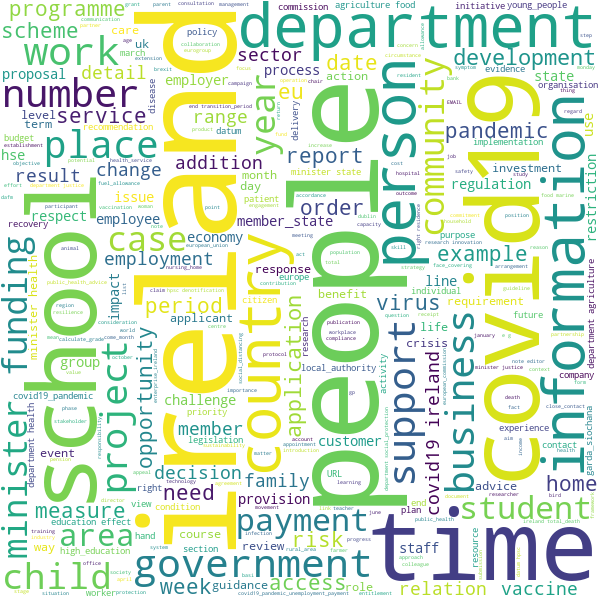

In [7]:
noun_phrase_corpus = spacy_corpus.apply(lambda x: x.noun_chunks)
noun_phrase_corpus = noun_phrase_corpus.apply(filter_stop_words_on_a_span_list)

generate_wordcloud(" ".join( [" ".join(doc) for doc in noun_phrase_corpus]) )

## Train LDA + LSI models

- create a dictionary and a corpus with each corpora
- train LDA models
- train LSI models
- visualize the results (LDA)

In [8]:
word_dictionary = gensim.corpora.Dictionary(word_corpus)
noun_dictionary = gensim.corpora.Dictionary(noun_corpus)
verb_dictionary = gensim.corpora.Dictionary(verb_corpus)
noun_phrases_dictionary = gensim.corpora.Dictionary(noun_phrase_corpus)

word_gensim_corpus = [word_dictionary.doc2bow(docs) for docs in word_corpus]
noun_gensim_corpus = [noun_dictionary.doc2bow(docs) for docs in noun_corpus]
verb_gensim_corpus = [verb_dictionary.doc2bow(docs) for docs in verb_corpus]
noun_phrases_gensim_corpus = [noun_phrases_dictionary.doc2bow(docs) for docs in noun_phrase_corpus]

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [9]:
word_lda_model = LdaModel(corpus=word_gensim_corpus, num_topics=5, id2word=word_dictionary, chunksize=30, random_state=40)
noun_lda_model = LdaModel(corpus=noun_gensim_corpus, num_topics=4, id2word=noun_dictionary, chunksize=30, random_state=40)
verb_lda_model = LdaModel(corpus=verb_gensim_corpus, num_topics=4, id2word=verb_dictionary, chunksize=20, random_state=40)
noun_phrases_lda_model = LdaModel(corpus=noun_phrases_gensim_corpus, num_topics=5, id2word=noun_phrases_dictionary, chunksize=30, random_state=40)

word_lsa_model = LsiModel(corpus=word_gensim_corpus, num_topics=6, id2word=word_dictionary, chunksize=300)
noun_lsa_model = LsiModel(corpus=noun_gensim_corpus, num_topics=6, id2word=noun_dictionary, chunksize=300)
verb_lsa_model = LsiModel(corpus=verb_gensim_corpus, num_topics=6, id2word=verb_dictionary, chunksize=300)
noun_phrases_lsa_model = LsiModel(corpus=noun_phrases_gensim_corpus, num_topics=6, id2word=noun_phrases_dictionary, chunksize=300)

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [10]:
pyLDAvis.enable_notebook()
word_visualization = pyLDAvis.gensim_models.prepare(word_lda_model, word_gensim_corpus, word_dictionary)
word_visualization

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.031874  0.016617       1        1  27.463056
1      0.133949  0.087403       2        1  19.767890
3      0.075305 -0.192414       3        1  19.476039
2      0.042389  0.086735       4        1  18.809074
0     -0.219770  0.001659       5        1  14.483941, topic_info=            Term         Freq        Total Category  logprob  loglift
234       health  2401.000000  2401.000000  Default  30.0000  30.0000
1367      school  1225.000000  1225.000000  Default  29.0000  29.0000
360       person  1219.000000  1219.000000  Default  28.0000  28.0000
136      covid19  1821.000000  1821.000000  Default  27.0000  27.0000
453        state  1449.000000  1449.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
274      ireland   254.732678  1890.054365   Topic5  -5.0813  -0.0720
613     european   186.040274   468.605075   Topic5  -5.3956   1.0083
380   protection   187.033107   548.342110   Topic5  -5.3903   0.8565
12             2   186.424230   537.880586   Topic5  -5.3935   0.8725
725          act   186.007637   638.688114   Topic5  -5.3958   0.6985

[411 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
4954      5  0.931877      +
1048      1  0.049083      /
1048      2  0.142341      /
1048      3  0.265868      /
1048      4  0.087532      /
...     ...       ...    ...
537       4  0.071944   year
537       5  0.107016   year
2369      1  0.034504  youth
2369      2  0.931611  youth
2369      3  0.017252  youth

[1064 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 2, 4, 3, 1])

In [11]:
noun_visualization = pyLDAvis.gensim_models.prepare(noun_lda_model, noun_gensim_corpus, noun_dictionary)
noun_visualization

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.075465 -0.013364       1        1  42.699979
1      0.201458 -0.049195       2        1  28.196072
2     -0.208518 -0.108474       3        1  15.188522
0     -0.068405  0.171034       4        1  13.915427, topic_info=            Term         Freq        Total Category  logprob  loglift
298       member  1207.000000  1207.000000  Default  30.0000  30.0000
137      payment   747.000000   747.000000  Default  29.0000  29.0000
140       person  1377.000000  1377.000000  Default  28.0000  28.0000
184        state  1341.000000  1341.000000  Default  27.0000  27.0000
318   regulation   806.000000   806.000000  Default  26.0000  26.0000
..           ...          ...          ...      ...      ...      ...
978        child   139.592399   719.071788   Topic4  -4.9938   0.3329
314    provision   105.523477   243.363027   Topic4  -5.2736   1.1366
881        union   119.956413   487.329494   Topic4  -5.1454   0.5704
638       school   129.095841  1017.176687   Topic4  -5.0719  -0.0921
6    application   110.602629   446.106198   Topic4  -5.2266   0.5776

[316 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
344       1  0.178124     act
344       3  0.096696     act
344       4  0.722675     act
501       1  0.746503  action
501       2  0.126133  action
...     ...       ...     ...
233       1  0.642482    year
233       2  0.212565    year
233       3  0.042130    year
233       4  0.102452    year
1433      3  0.960766    zone

[705 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 3, 1])

t-SNE for noun_lda_model

In [12]:
# Get the topics weights (nr. of docs. x nr. of topics)
weights = np.zeros((len(ireland_timeline), 4))

for doc_nr, topics_info in enumerate(noun_lda_model[noun_gensim_corpus]):
    for topic_info in topics_info:
        topic_idx = topic_info[0]
        topic_weight = topic_info[1]
        weights[doc_nr][topic_idx] = topic_weight

# Dominant topic number in each doc
dominant_topics = np.argmax(weights, axis=1)

# t-SNE Dimension Reduction
t_sne_model = TSNE(n_components=2, verbose=1, random_state=42)
t_sne_lda = t_sne_model.fit_transform(weights)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
colors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])

source = ColumnDataSource(dict(
    x=t_sne_lda[:,0],
    y=t_sne_lda[:,1],
    color=colors[dominant_topics],
    label=pd.Series(dominant_topics).apply(lambda x: "Topic " + str(x + 1))
))

plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics),
              plot_width=900, plot_height=700)

plot.scatter(x="x", y="y", color="color", legend_group="label", source=source)

# Display legend in the top left corner
plot.legend.location = "top_left"

# Add a title to your legend
plot.legend.title = "Topics"

show(plot)

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/opt/conda/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:349: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

/opt/conda/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:350: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify a

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 410 samples in 0.000s...
[t-SNE] Computed neighbors for 410 samples in 0.004s...
[t-SNE] Computed conditional probabilities for sample 410 / 410
[t-SNE] Mean sigma: 0.012158
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.661747


/opt/conda/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:349: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

/opt/conda/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:350: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



[t-SNE] KL divergence after 1000 iterations: 0.308252


Loading BokehJS ...

In [13]:
verb_visualization = pyLDAvis.gensim_models.prepare(verb_lda_model, verb_gensim_corpus, verb_dictionary)
verb_visualization

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.089418 -0.012943       1        1  39.732526
3     -0.192896  0.056228       2        1  25.766874
2      0.087207 -0.168064       3        1  24.868930
0      0.195107  0.124778       4        1   9.631669, topic_info=        Term        Freq        Total Category  logprob  loglift
857   reside  307.000000   307.000000  Default  30.0000  30.0000
5      apply  453.000000   453.000000  Default  29.0000  29.0000
131  support  955.000000   955.000000  Default  28.0000  28.0000
499    grant  204.000000   204.000000  Default  27.0000  27.0000
157  confirm  307.000000   307.000000  Default  26.0000  26.0000
..       ...         ...          ...      ...      ...      ...
100  provide   71.424102  1112.214296   Topic4  -4.2213  -0.4054
221  require   50.141721   592.375608   Topic4  -4.5751  -0.1292
54      give   44.491835   467.507931   Topic4  -4.6946  -0.0120
470    refer   34.752319   160.149978   Topic4  -4.9417   0.8122
186      set   34.683423   294.363969   Topic4  -4.9437   0.2016

[295 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
347       1  0.912720       absorb
348       1  0.975522   accelerate
520       1  0.980472       accept
308       1  0.914010  acknowledge
308       2  0.058341  acknowledge
...     ...       ...          ...
150       2  0.319655         work
150       3  0.038054         work
150       4  0.085894         work
737       1  0.075643       worsen
737       2  0.907717       worsen

[616 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 3, 1])

In [14]:
noun_phrases_visualization = pyLDAvis.gensim_models.prepare(noun_phrases_lda_model, noun_phrases_gensim_corpus, noun_phrases_dictionary)
noun_phrases_visualization


/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.068555  0.132372       1        1  24.798037
2     -0.038424  0.037320       2        1  20.912881
0     -0.104648 -0.146875       3        1  19.556498
3      0.023988  0.003545       4        1  19.159498
1      0.187638 -0.026362       5        1  15.573087, topic_info=             Term        Freq       Total Category  logprob  loglift
61        covid19  737.000000  737.000000  Default  30.0000  30.0000
179        person  874.000000  874.000000  Default  29.0000  29.0000
1008       school  562.000000  562.000000  Default  28.0000  28.0000
1965        child  428.000000  428.000000  Default  27.0000  27.0000
634         state  847.000000  847.000000  Default  26.0000  26.0000
...           ...         ...         ...      ...      ...      ...
399    regulation   82.464642  410.549888   Topic5  -5.4250   0.2545
134   information   80.469750  386.460437   Topic5  -5.4495   0.2905
178        people   91.658260  642.802562   Topic5  -5.3193  -0.0881
70          datum   58.772420  147.875568   Topic5  -5.7637   0.9369
75     department   57.623162  694.072538   Topic5  -5.7834  -0.6290

[361 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
9592      3  0.929991  12_month
1706      5  0.985711    14_day
8493      3  0.944782    2_year
8493      4  0.039366    2_year
5485      1  0.068978   3_month
...     ...       ...       ...
275       1  0.323615      year
275       2  0.538186      year
275       3  0.087939      year
275       4  0.045728      year
275       5  0.007035      year

[806 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 3, 1, 4, 2])